# **AB Testing on Mobile Games**

**About the dataset:**

Cookie Cats, developed by Tactile Entertainment, is an immensely popular mobile puzzle game that combines the "connect three" gameplay mechanic with singing cats. As players advance in the game, they encounter gates that introduce waiting time or offer in-app purchases. This project focuses on analyzing the results of an A/B test conducted in Cookie Cats, specifically examining the effects of moving the first gate from level 30 to level 40. The analysis will primarily focus on player retention and game rounds to assess the impact of this change.

Found here on [Kaggle](https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing?resource=download)

In [203]:
# import libraties

import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

In [204]:
df = pd.read_csv('cookie_cats.csv')

###### **Choosing the metric**

While click-through rate (CTR) and conversion rate are important metrics in other contexts, they are not relevant for A/B testing retention given our data. On the other hand,  Retention rate measures the ability of the app to retain users over a specific time period, indicating their long-term engagement. It provides insights into which version of the app is successful in keeping users coming back and using it consistently.  Because of this, we will choose retetion rate for our metric. By prioritizing retention rate, we align our testing efforts with the key goals of creating an engaging, enjoyable, and sticky game app experience that encourages users to keep coming back, resulting in higher user satisfaction, longer user retention, and increased revenue potential.

**Retetion Rate**

    *   Retention Rate = (Number of users retained in variation / Number of users in variation) * 100
    *   List item

To calculate the retention rate for each variation, we need to determine the number of users who continue to use the app from the initial sample population of each variation within the specified time period. We will then compare the retention rates of the experimental and control variations, to determine which variation has a higher rate of user retention.


###### **Stating the hypothesis**



*   Null Hypothesis (H0): Moving the first gate from level 30 to level 40 in Cookie Cats has no significant impact on player retention and game rounds.
*   Alternative Hypothesis (H1): Moving the first gate from level 30 to level 40 in Cookie Cats leads to a significant difference in player retention and game rounds.

In other words, the null hypothesis assumes that there will be no meaningful difference in player retention and game rounds between the control group (gate_30) and the test group (gate_40) when the first gate is moved. The alternative hypothesis suggests that there will be a notable difference in player retention and game rounds between the two groups due to the change in gate placement.

During our analysis, we will evaluate the data and perform statistical tests to either accept or reject the null hypothesis based on the evidence and insights gained from the dataset.



###### **Designing the A/B test**

For power test and significance level we will stick to the common practice of 80% as the power of the A/B test and 5% as the significance level

#### **Getting familiar with the data**

5 columns and 90,189 rows

userid - a unique number that identifies each player.

version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).

sum_gamerounds - the number of game rounds played by the player during the first week after installation

retention_1 - did the player come back and play 1 day after installing?

retention_7 - did the player come back and play 7 days after installing?

The test period was 14 days

There are no missing values

The are no duplicates



In [205]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [206]:
df.shape

(90189, 5)

In [207]:
df.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

In [208]:
df.isna().any()

userid            False
version           False
sum_gamerounds    False
retention_1       False
retention_7       False
dtype: bool

In [209]:
df.duplicated().any()

False

In [210]:
#verifying the presence of only two versions
df['version'].unique()

array(['gate_30', 'gate_40'], dtype=object)

In [211]:
#how many users in each group

df.groupby(['version'])['userid'].nunique()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

###### **Summary Statistics**




*   There are 44,700 observations for gate_30 and 45,489 observations for gate_40.
*   For gate_30, the median is 17, indicating that 50% of the players in this group played 17 or fewer game rounds. Similarly, for gate_40, the median is 16.
*   For gate_30, the mean is approximately 52.46, indicating that on average, players in this group played 52.46 game rounds. For gate_40, the mean is around 51.30, representing the average game rounds played by players in that group.
*   For gate_30, the standard deviation is 256.72, indicating a relatively large spread of data points around the mean. In contrast, for gate_40, the standard deviation is 103.29, suggesting a smaller spread of data points.
*   The max value for gate_30 is 49,854, while for gate_40, it is 2,640. This indicates that the highest number of game rounds played by a player in gate_30 is significantly larger compared to gate_40.
*   List item







In [212]:
# statistics based of number of games rounds played by users

df.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max", "min"])

,count,median,mean,std,max,min
version,,,,,,
gate_30,44700,17.0,52.456264,256.716423,49854,0
gate_40,45489,16.0,51.298776,103.294416,2640,0


###### **Outliers**

Version 30 had an extreme outlier that was removed for Data Accuracy and Normality Assumption, among other reasons (Robustness and Comparability).



*   Data Accuracy: Extreme outliers can distort the overall picture of the data and lead to inaccurate insights and conclusions. By removing these outliers, we obtain a more accurate representation of the majority of the data points, allowing for more reliable analysis.
*   Normality Assumption: Many statistical techniques assume that the data follows a normal distribution or at least approximate normality. Extreme outliers can violate this assumption and affect the validity of statistical tests and models. Removing outliers helps to restore the normality assumption, enabling the use of appropriate statistical methods.



After removing the outlier (maximum value from version starting at gate 30), the standard deviation for "gate_30" decreased significantly from 256.716423 to 102.057598. As a result, the standard deviation for "gate_30" is now closer to the standard deviation of "gate_40", making it more comparable to the spread of the "gate_40" version.

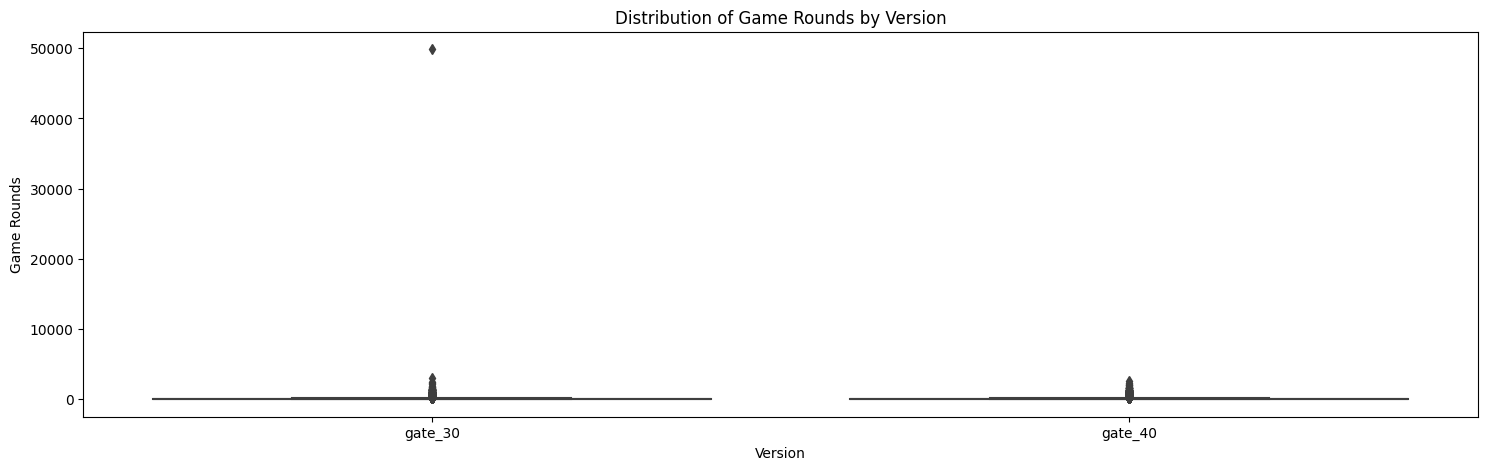

In [213]:
# looking for outliers

plt.figure(figsize=(18, 5))
sns.boxplot(x='version', y='sum_gamerounds', data=df)
plt.xlabel('Version')
plt.ylabel('Game Rounds')
plt.title('Distribution of Game Rounds by Version')
plt.show()

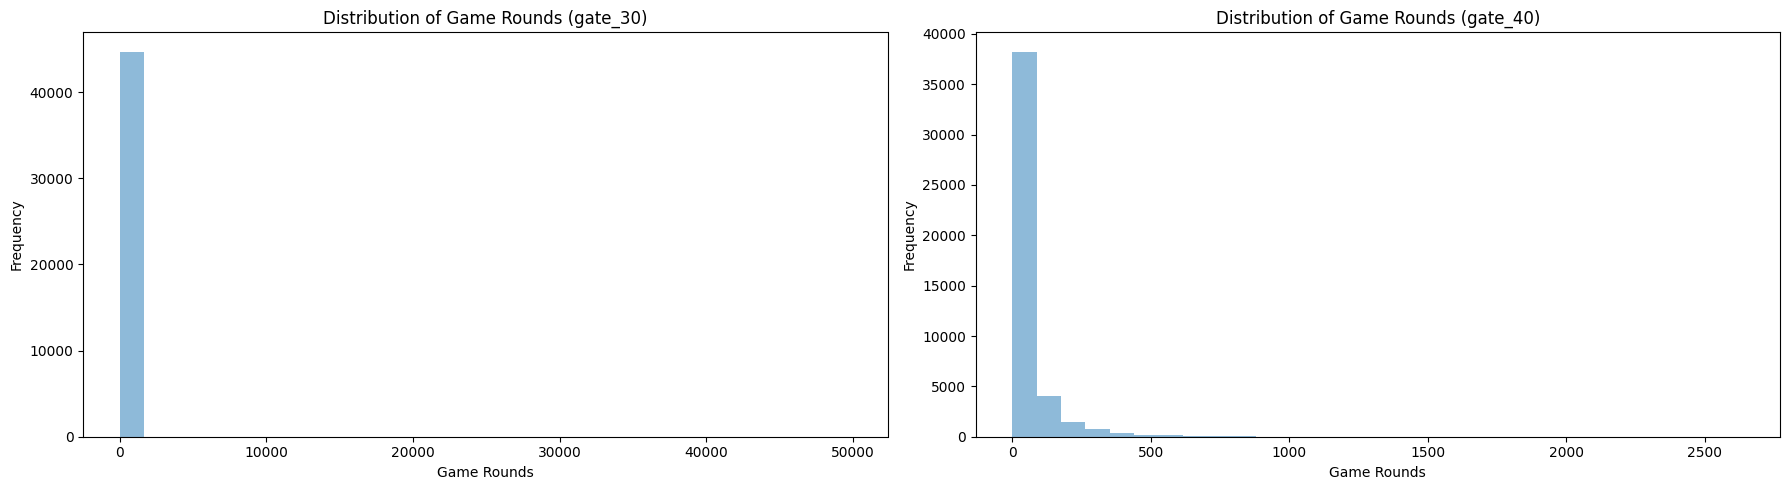

In [214]:
# Histograms to visualize distribution

gate_30_data = df[df['version'] == 'gate_30']
gate_40_data = df[df['version'] == 'gate_40']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 5))  # 1 row, 2 columns

# Plot histogram for gate_30
axes[0].hist(gate_30_data['sum_gamerounds'], bins=30, alpha=0.5)
axes[0].set_xlabel('Game Rounds')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Game Rounds (gate_30)')

# Plot histogram for gate_40
axes[1].hist(gate_40_data['sum_gamerounds'], bins=30, alpha=0.5)
axes[1].set_xlabel('Game Rounds')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Game Rounds (gate_40)')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()



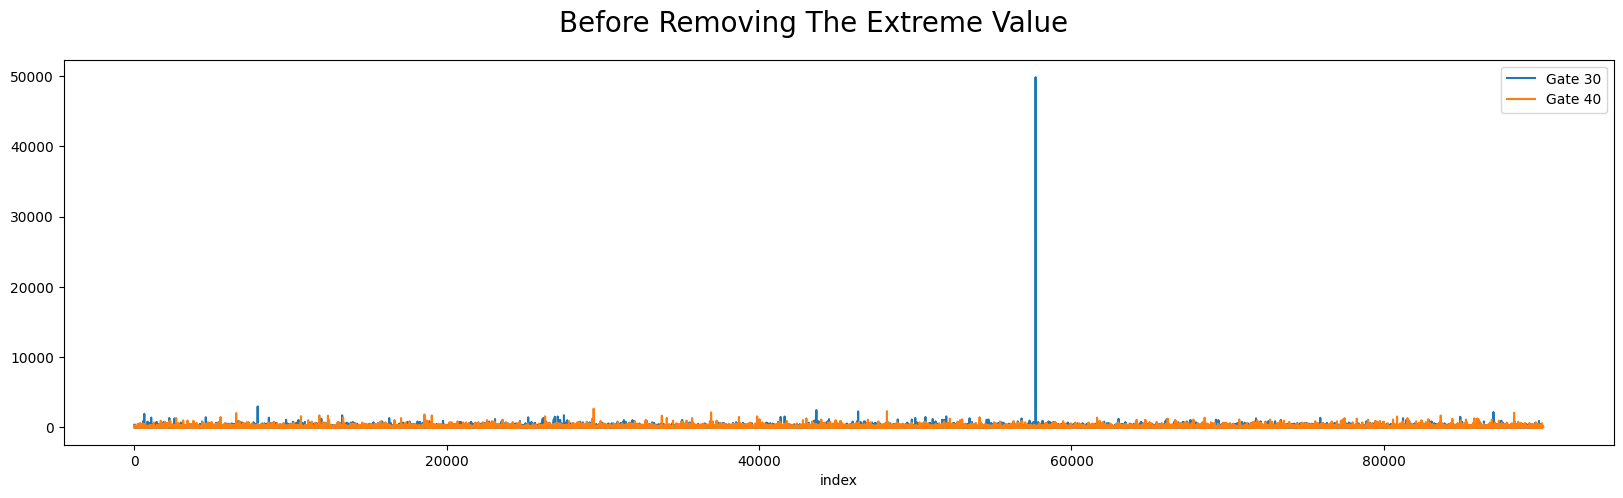

In [215]:
df[df.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
df[df.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40")
plt.suptitle("Before Removing The Extreme Value", fontsize = 20);

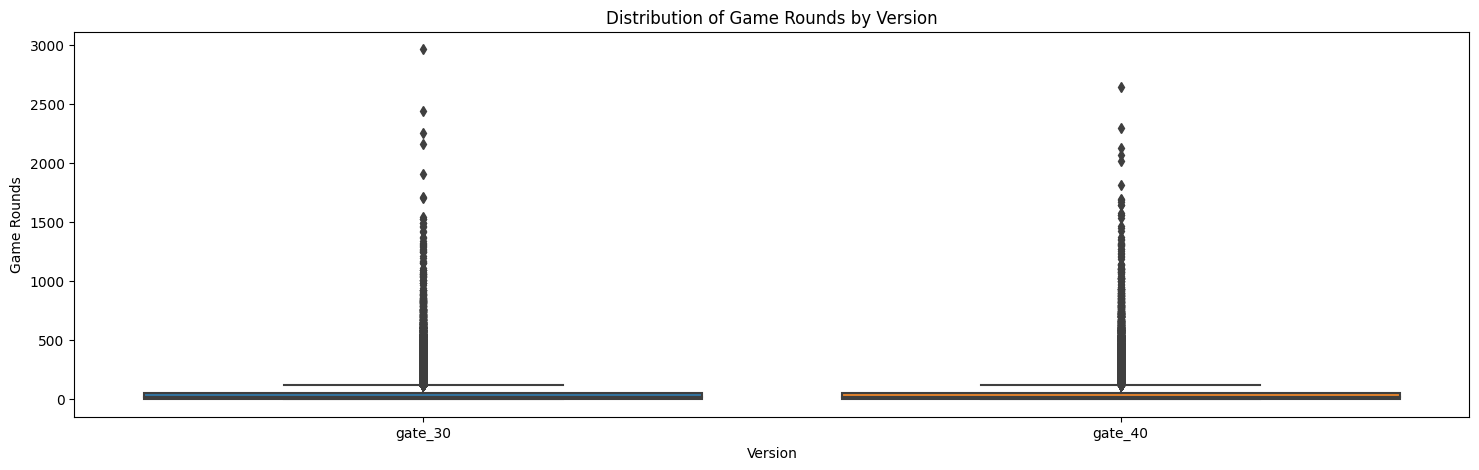

In [216]:
#removing the outlier

df = df[df.sum_gamerounds < df.sum_gamerounds.max()]

plt.figure(figsize=(18, 5))
sns.boxplot(x='version', y='sum_gamerounds', data=df)
plt.xlabel('Version')
plt.ylabel('Game Rounds')
plt.title('Distribution of Game Rounds by Version')
plt.show()

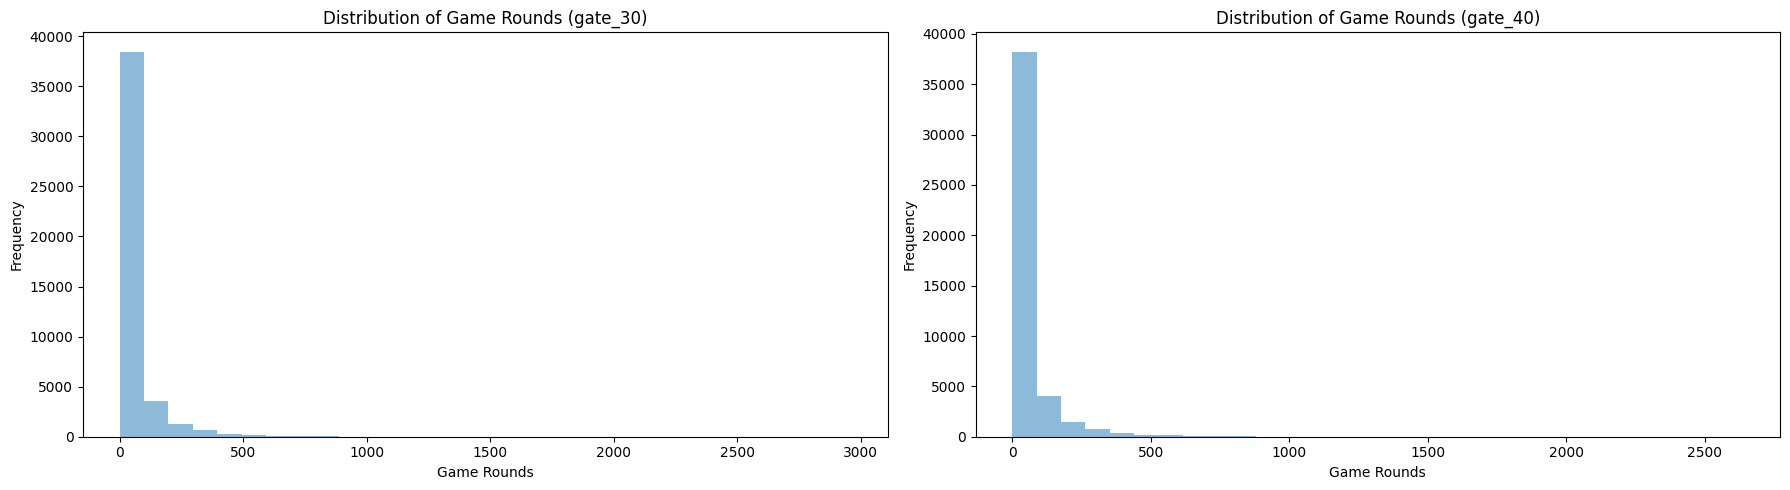

In [217]:
# Histograms to visualize distribution

gate_30_data = df[df['version'] == 'gate_30']
gate_40_data = df[df['version'] == 'gate_40']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 5))  # 1 row, 2 columns

# Plot histogram for gate_30
axes[0].hist(gate_30_data['sum_gamerounds'], bins=30, alpha=0.5)
axes[0].set_xlabel('Game Rounds')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Game Rounds (gate_30)')

# Plot histogram for gate_40
axes[1].hist(gate_40_data['sum_gamerounds'], bins=30, alpha=0.5)
axes[1].set_xlabel('Game Rounds')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Game Rounds (gate_40)')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

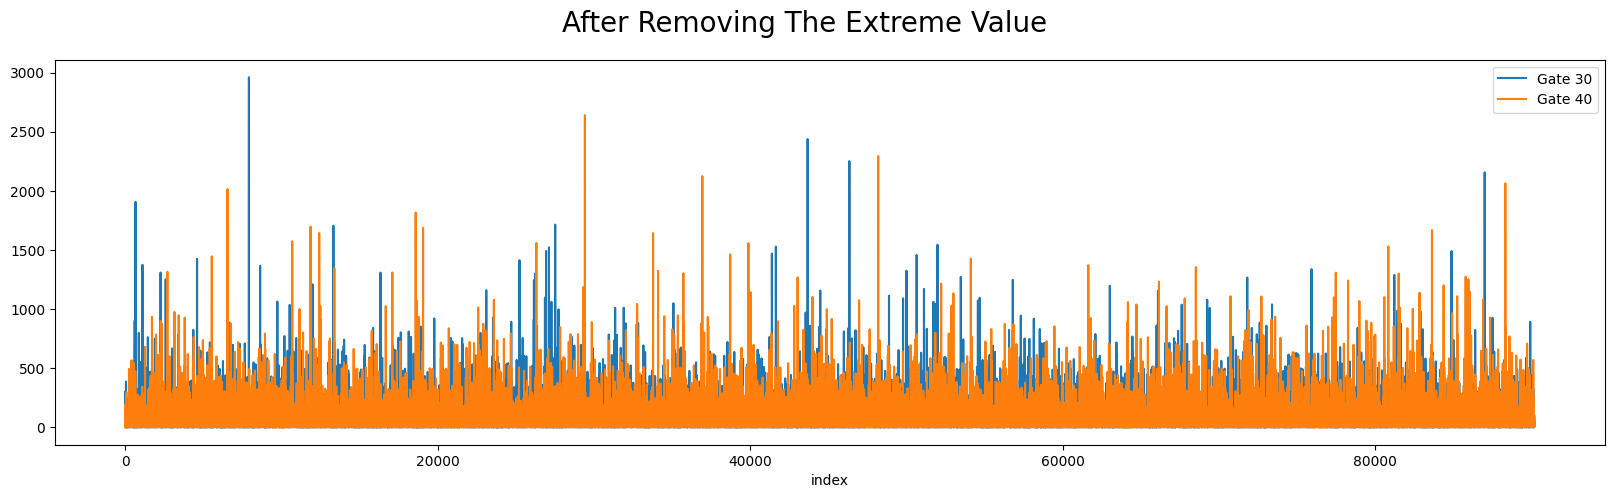

In [218]:
df[df.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
df[df.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40")
plt.suptitle("After Removing The Extreme Value", fontsize = 20);

In [219]:
# statistics after removing the outlier

df.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max", "min"])

,count,median,mean,std,max,min
version,,,,,,
gate_30,44699,17.0,51.342111,102.057598,2961,0
gate_40,45489,16.0,51.298776,103.294416,2640,0


###### **Interpreting the Data**

Since we had min of 0, I'm curious the distribution of people who never played the game after installing.

Looks like more people who had version gate_30 never came back to play. But the differnce is relatively small, 120.

 Would be curious to know if these people ever opened the app because there could be potention here. If these people downloaded the app and forgot it was on their phone, it might be good to consider what might be a good way to remind them they have the app and have yet to try it.

In [220]:
# Count the number of people who never played and had version gate_30
never_played_gate_30 = len(df[(df['sum_gamerounds'] == 0) & (df['version'] == 'gate_30')])

# Count the number of people who never played and had version gate_40
never_played_gate_40 = len(df[(df['sum_gamerounds'] == 0) & (df['version'] == 'gate_40')])

# Create a DataFrame with the counts
table_data = {'Version': ['gate_30', 'gate_40', 'Total'],
              'Number of people who never played': [never_played_gate_30, never_played_gate_40, never_played_gate_30 + never_played_gate_40]}

table_df = pd.DataFrame(table_data)

# Display the table
table_df


,Version,Number of people who never played
0,gate_30,1937
1,gate_40,2057
2,Total,3994


Based on the analysis, it is observed that a significant proportion of players either discontinued playing or did not engage with the game at all. However, among those who continued playing after the first day, a higher count of players were still actively engaged after seven days, as indicated by the bar charts. Specifically, approximately 6,900 players were still playing after seven days, compared to around 1,900 players who had stopped playing.

Conversely, after one day, the count of players who had discontinued playing surpassed those who were still actively engaged. This is evident in both Version A and Version B, with over 20,000 players ceasing to play compared to fewer than 15,000 players who continued playing.

The analysis reveals that 55% of players did not play the game one day after installing it, while 81% did not play after seven days. This indicates a high drop-off rate within the first week of installation.

When comparing retention rates between the different versions, the data shows a similar distribution of players who continued playing after one or seven days. This suggests that the version change from gate_30 to gate_40 did not have a significant impact on player retention within the observed timeframe.

Overall, these findings highlight the need to further investigate the factors contributing to the drop-off in player engagement and to explore strategies to improve player retention in the early stages of the game.

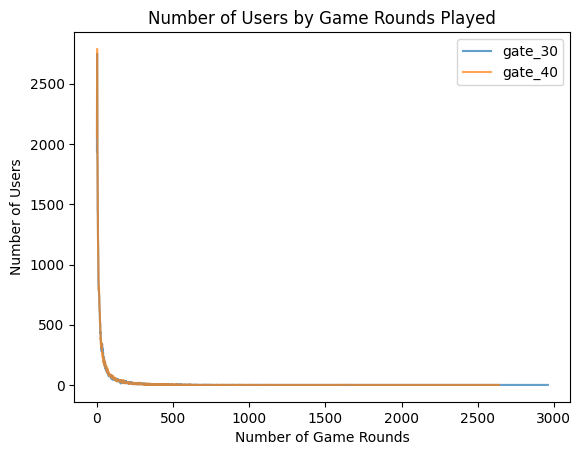

In [221]:
# Filter the data for version gate_30
gate_30_data = df[df['version'] == 'gate_30']

# Filter the data for version gate_40
gate_40_data = df[df['version'] == 'gate_40']

# Count the number of users for each game round count for each version
round_counts_gate_30 = gate_30_data['sum_gamerounds'].value_counts().sort_index()
round_counts_gate_40 = gate_40_data['sum_gamerounds'].value_counts().sort_index()

# Generate the x-axis values (sum_gamerounds) and y-axis values (user count) for each version
x_gate_30 = round_counts_gate_30.index
y_gate_30 = round_counts_gate_30.values

x_gate_40 = round_counts_gate_40.index
y_gate_40 = round_counts_gate_40.values

# Plot the line charts for each version with transparency
plt.plot(x_gate_30, y_gate_30, label='gate_30', alpha=0.7)
plt.plot(x_gate_40, y_gate_40, label='gate_40', alpha=0.7)

plt.xlabel('Number of Game Rounds')
plt.ylabel('Number of Users')
plt.title('Number of Users by Game Rounds Played')
plt.legend()
plt.show()


In [222]:
pd.DataFrame({"RET1_COUNT": df["retention_1"].value_counts(),
              "RET7_COUNT": df["retention_7"].value_counts(),
              "RET1_RATIO": df["retention_1"].value_counts() / len(df),
              "RET7_RATIO": df["retention_7"].value_counts() / len(df)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50035,73408,0.554786,0.813944
True,40153,16780,0.445214,0.186056


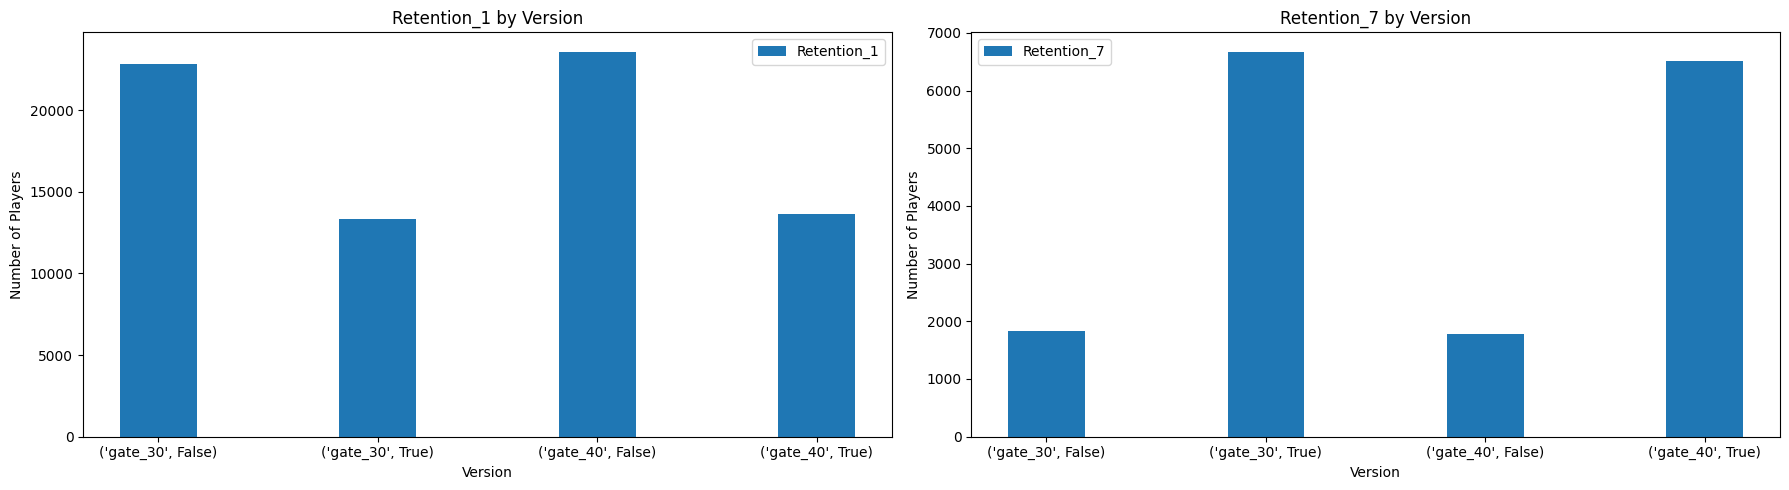

In [223]:
# Count the number of players for each retention status and version
retention_counts = df.groupby(['version', 'retention_1', 'retention_7']).size().unstack(fill_value=0)

# Get the number of versions and retention statuses
num_versions = retention_counts.shape[0]
num_retention_statuses = retention_counts.shape[1]

# Set the width of each bar
bar_width = 0.35

# Generate the x-axis values
x = np.arange(num_versions)

# Create the subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot the bar chart for retention_1
axes[0].bar(x, retention_counts.iloc[:, 0], width=bar_width, label='Retention_1')

axes[0].set_xlabel('Version')
axes[0].set_ylabel('Number of Players')
axes[0].set_title('Retention_1 by Version')
axes[0].set_xticks(x)
axes[0].set_xticklabels(retention_counts.index)
axes[0].legend()

# Plot the bar chart for retention_7
axes[1].bar(x, retention_counts.iloc[:, 1], width=bar_width, label='Retention_7')

axes[1].set_xlabel('Version')
axes[1].set_ylabel('Number of Players')
axes[1].set_title('Retention_7 by Version')
axes[1].set_xticks(x)
axes[1].set_xticklabels(retention_counts.index)
axes[1].legend()

plt.tight_layout()
plt.show()


#### **Results**

**Retention Rate**

The retention rates of the experimental and control variations, are 18.2 and 19.0 respectifully. The conrol variation has a higher rate of user retention.

**Hypothesis Test**

The reults suggest we Reject the null hypothesis that "Moving the first gate from level 30 to level 40 in Cookie Cats has no significant impact on player retention and game rounds."

Based on these results, it indicates that moving the first gate from level 30 to level 40 in the mobile app has a negative impact on user retention. The control group, with the gate at level 30, shows higher retention rates compared to the experimental group with the gate at level 40.

In [224]:
# Initialize retention_rate column with NaN values
df['retention_rate'] = np.nan

# Calculate retention rate for control group
control_retained = df[(df['version'] == 'gate_30') & (df['retention_7'] == True)]['userid'].nunique()
control_total = df[df['version'] == 'gate_30']['userid'].nunique()
control_retention_rate = (control_retained / control_total) * 100

# Calculate retention rate for test group
test_retained = df[(df['version'] == 'gate_40') & (df['retention_7'] == True)]['userid'].nunique()
test_total = df[df['version'] == 'gate_40']['userid'].nunique()
test_retention_rate = (test_retained / test_total) * 100

# Assign retention rates based on the 'version' column
df.loc[df['version'] == 'gate_30', 'retention_rate'] = control_retention_rate
df.loc[df['version'] == 'gate_40', 'retention_rate'] = test_retention_rate

# Print retention rates
print("Retention Rate - Control Group:", control_retention_rate)
print("Retention Rate - Test Group:", test_retention_rate)


Retention Rate - Control Group: 19.018322557551624
Retention Rate - Test Group: 18.200004396667328


In [225]:
# Adding retention column

df["retention"] = np.where((df.retention_1 == True) & (df.retention_7 == True), 1,0)
df.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7,retention_rate,retention
0,116,gate_30,3,False,False,19.018323,0
1,337,gate_30,38,True,False,19.018323,0
2,377,gate_40,165,True,False,18.200004,0
3,483,gate_40,1,False,False,18.200004,0
4,488,gate_40,179,True,True,18.200004,1


**restating the hypothesis**
Null Hypothesis (H0): Moving the first gate from level 30 to level 40 in Cookie Cats has no significant impact on player retention and game rounds.
Alternative Hypothesis (H1): Moving the first gate from level 30 to level 40 in Cookie Cats leads to a significant difference in player retention and game rounds.

In [226]:
# A/B Testing Function - Quick Solution
def AB_Test(dataframe, group, target):

    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats

    # Split A/B
    groupA = df[df[group] == "gate_30"][target]
    groupB = df[df[group] == "gate_40"][target]

    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True

    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True

        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1]
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True

    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05],
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "Moving the first gate from level 30 to level 40 in Cookie Cats has no significant impact on player retention and game rounds", "Moving the first gate from level 30 to level 40 in Cookie Cats leads to a significant difference in player retention and game rounds.")

    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]

    return temp



# Apply A/B Testing
AB_Test(dataframe=df, group = "version", target = "retention_rate")

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:2710: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
<ipython-input-226-a691c4f04a1a>:27: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]


,Test Type,Homogeneity,AB Hypothesis,p-value,Comment
0,Parametric,Yes,Reject H0,0.0,Moving the first gate from level 30 to level 4...


##### **Note on the P-value**

The above was performed with both retetion (binary) variable and retetion_rate (continuous). Using retetion returned a p_value of 0.007127 and the Test Type was Non-paramatic. Although the statistical tests provide different p-values, both results ultimately lead to the same conclusion of rejecting the null hypothesis. This indicates that there is a significant difference in retention between the experimental and control groups, regardless of whether you consider the binary "retention" or the continuous "retention rate" variable. I decided to stick with evaluting the data based on the retention rate because I believe this variable provides a more nuanced understanding by considering the actual proportion of users retained, rather than just a binary indication of retention or non-retention.




#### **Conclusions:**
Based our analysis, here are some additional points to consider:


1.   Difference in Retention Rates: The experimental variation (gate_40) has a significantly lower retention rate of 18.2% compared to the control variation (gate_30) with a retention rate of 19.0%. This indicates that, on average, a higher percentage of users are retained in the control group.

1.   Magnitude of the Difference: The difference in retention rates between the two groups is small but statistically significant, with a 0.8 percentage point difference. This suggests that even a slight change in the gate's position from level 30 to level 40 has a meaningful impact on user retention.
2.   Statistical Significance: The obtained p-value of 0.0 indicates strong evidence against the null hypothesis, supporting the conclusion that the observed difference in retention rates is not due to random chance. This finding reinforces the significance of the difference and increases confidence in the results.
3.   Implications for Decision Making: The significantly lower retention rate in the experimental group raises concerns about the effectiveness of moving the first gate to level 40. It suggests that this change has a negative impact on user retention. Retaining the gate at level 30 appears to be more beneficial for retaining users in the mobile app.
4.   Limitations and Future Research: It's important to acknowledge that retention rates alone may not provide a complete understanding of user behavior and the overall impact of the gate's position on user engagement or revenue generation. Future research could explore additional factors, such as user engagement metrics or conduct qualitative analysis, to gain deeper insights into user preferences and motivations.











